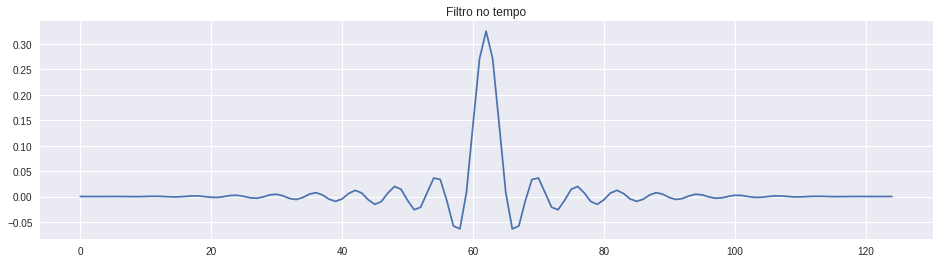

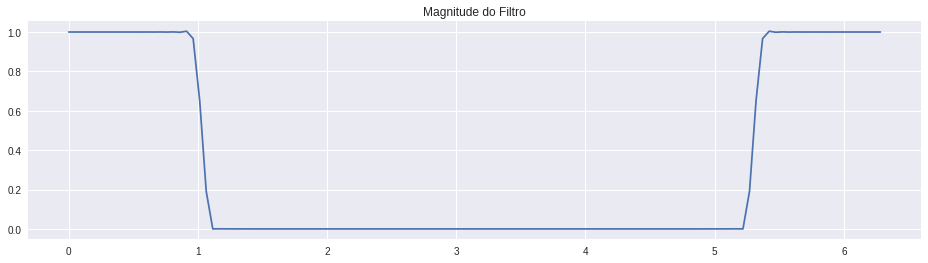

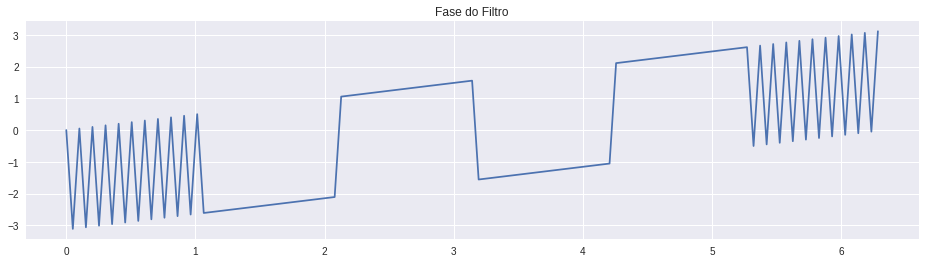

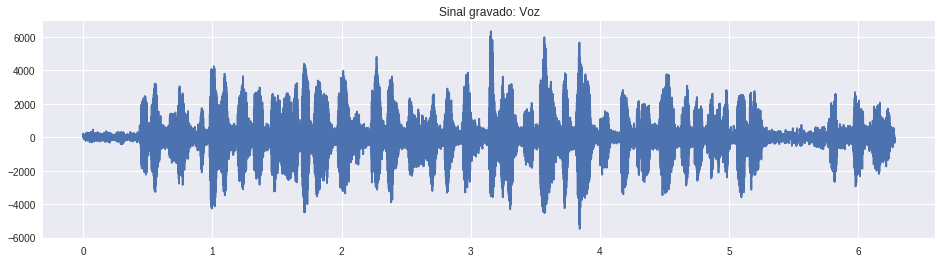

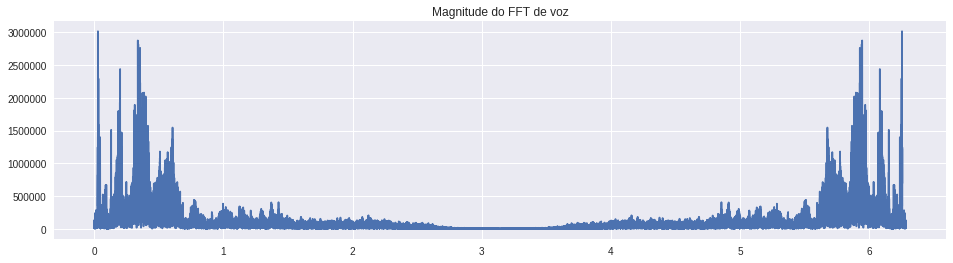

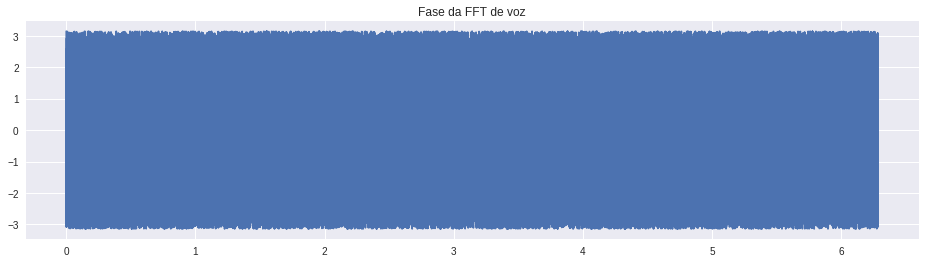

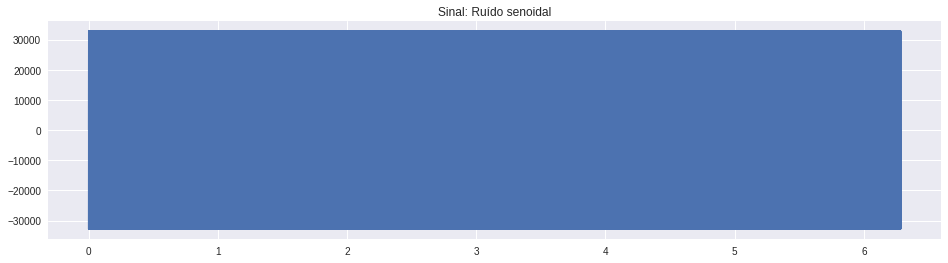

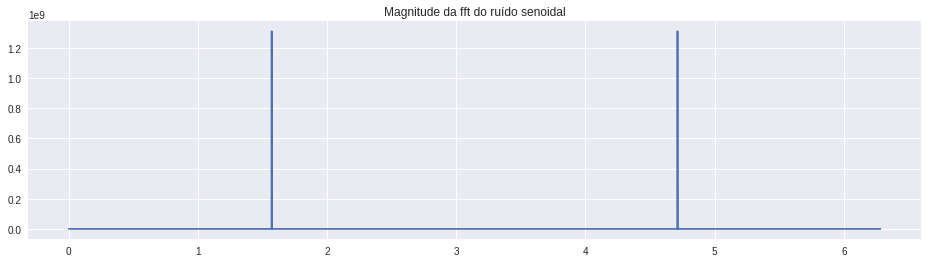

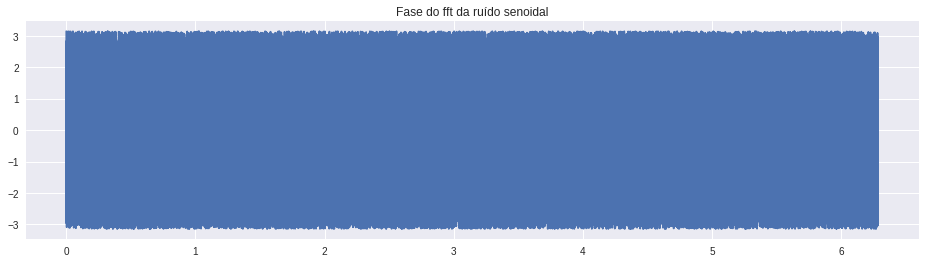

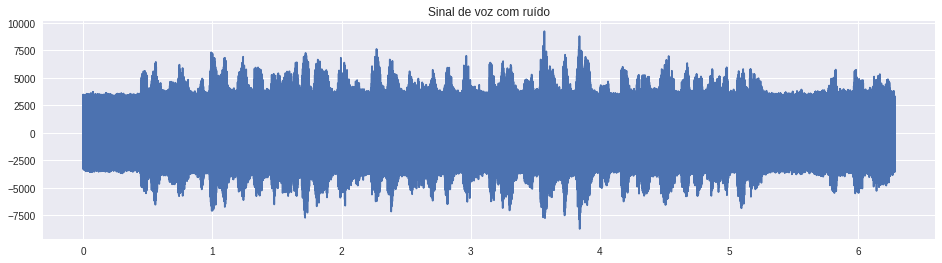

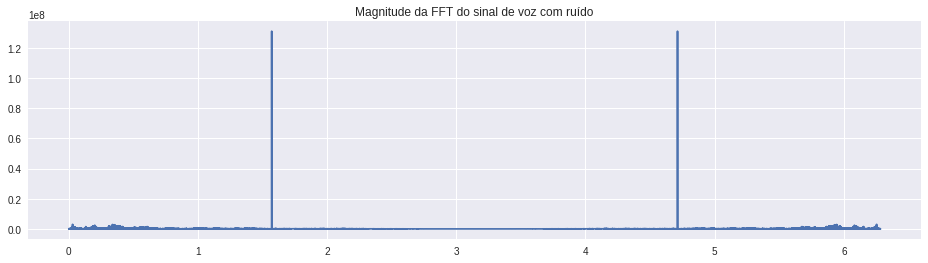

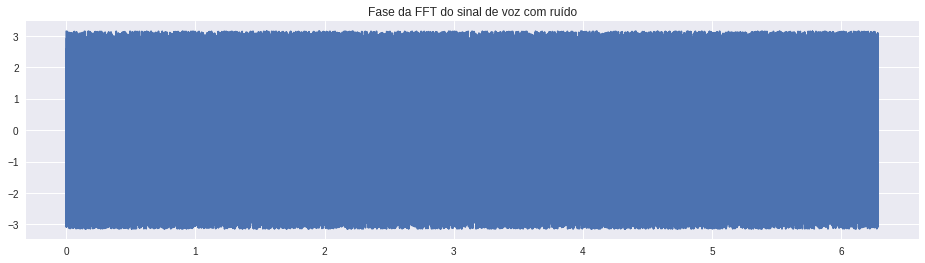

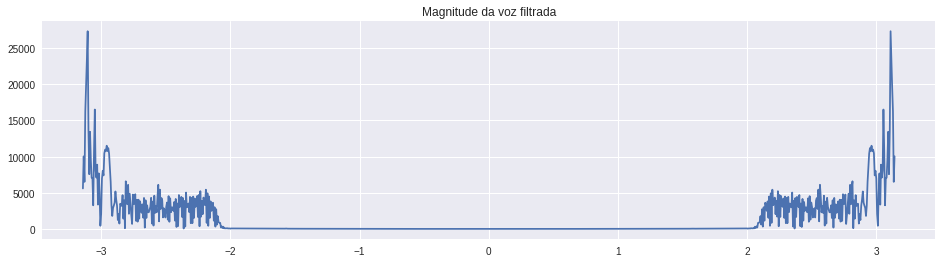

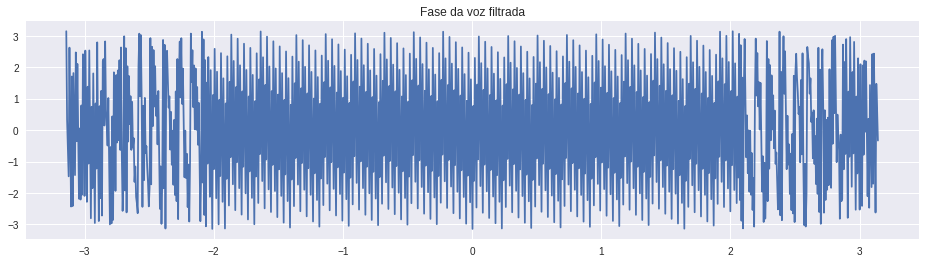

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import IPython.display as ipd

def plot(y,title,*args):
    plt.figure(figsize=(16,4))
    plt.title(title)
    if(args):
      plt.plot(args[0],y)
    else:
      plt.plot(y)
    plt.show()
    
def calcular_numero_de_zeros(vetor):
    return int(2**np.ceil(np.log2(len(vetor))) - len(vetor))

def complete_zeros(n, vector):
  return np.concatenate([vector, np.zeros(n)])

def get_fft_index(i,width):
  i_fft= '{:0{width}b}'.format(i, width = width)
  return int(i_fft[::-1],2)

def org_index_fft(size_fft):
  org_index_fft = []
  for i in np.arange(0,size_fft):
    numbits = int(np.ceil(np.log2(size_fft)))
    org_index_fft.append(get_fft_index(i,numbits))
  return org_index_fft

def wN(N, signal):
  return np.exp(signal*1j*2*np.pi/N)

def fft(fact,N, vec=[]):
  size_v = len(vec)//2
  p1 = vec[0:len(vec)//2]
  p2 = vec[len(vec)//2:]
  if size_v == 1:
    g = vec[0] + vec[1]
    h = vec[0] - vec[1]
    return np.array([g,h])
  else: 
    wNs_tam = size_v
    Wns = wN(N, -1)**[(fact*i) for i in np.arange(0,wNs_tam)]
    
    g = p1 + p2
    h = (p1 - p2)*Wns
    
    fact = fact*2
    
    g = fft(fact, N, g)
    h = fft(fact, N, h)
  fft_ = np.concatenate([g,h])
  if fact == 2:
    fft_ = fft_[org_index_fft(len(fft_))]
  return fft_

def inverse_fft(fact,N, vec):
    size_v = len(vec)//2
    p1 = vec[0:len(vec)//2]
    p2 = vec[len(vec)//2:]
    
    if size_v == 1:
      g = vec[0] + vec[1]
      h = vec[0] - vec[1]
      return np.array([g,h])
    
    else: 
      wNs_tam = size_v
      Wns = wN(N, 1)**[(fact*i) for i in np.arange(0,wNs_tam)]
      
      g = p1 + p2
      h = (p1 - p2)*Wns

      fact = fact*2
      
      g =inverse_fft(fact, N, g)
      h = inverse_fft(fact, N, h)
      
      fft_ = np.concatenate([g,h])
      if fact == 2:
        fft_ = (fft_[org_index_fft(len(fft_))])/N
      return fft_
    
    
def overlap_save(N, x, h):
  M = int(len(h))
  L = N - M + 1 
  tam_x_in = L - (M-1)
  
  number_blocks_x = int(np.ceil(len(x)/L))
    
  y = np.zeros(0, dtype='complex')
  h = complete_zeros((N-M),h)
  not_div_flag = False
  
  if(len(x) % N != 0):
    not_div_flag = True

  x_block = np.concatenate([np.zeros(M-1), x[0: L]])
  
  conv_freq = fft(1, N,x_block)* fft(1, N, h)
  conv_temp = inverse_fft(1, N, conv_freq)
  
  y = np.concatenate([y,conv_temp[(M-1):]])
  for j in np.arange(1, number_blocks_x):
    x_block = x[j*L - (M-1) : ((j+1)*L)]
    
  if(j == (number_blocks_x -1) and not_div_flag):
    num_zeros_add = N-len(x_block)
    x_block = np.concatenate([x_block, np.zeros(num_zeros_add)])
    
    h_jw = fft(1, N, h)
    x_block_jw = fft(1, N, x_block)
    
    conv_temp = inverse_fft(1, N, h_jw*x_block_jw)
    
    y = np.concatenate([y,conv_temp[(M-1):]])
  return y

n = np.arange(0,125)
h = ((np.sinc(0.325*(n-62)))*(0.325))*(0.5-0.5*np.cos(2*np.pi*n/124))

h_jw = np.fft.fft(h)
plot(h, "Filtro no tempo")
plot(np.absolute(h_jw),"Magnitude do Filtro",np.linspace(0,2*np.pi, len(h)))
plot(np.angle(h_jw),"Fase do Filtro", np.linspace(0,2*np.pi, len(h)))

fs, data_voz = wavfile.read('voz.wav')
fs, data_ruido = wavfile.read('ruido.wav')

fff_voz = np.fft.fft(data_voz)

plot(np.real(data_voz), 'Sinal gravado: Voz',
     np.linspace(0,2*np.pi, len(data_voz)))
plot(np.absolute(fff_voz), 'Magnitude do FFT de voz',
     np.linspace(0,2*np.pi, len(fff_voz)))
plot(np.angle(fff_voz), 'Fase da FFT de voz',
     np.linspace(0,2*np.pi, len(fff_voz)))

fft_ruido = np.fft.fft(data_ruido)

plot(np.real(data_ruido), 'Sinal: Ruído senoidal',
     np.linspace(0,2*np.pi, len(data_ruido)))
plot(np.absolute(fft_ruido), 'Magnitude da fft do ruído senoidal',
     np.linspace(0,2*np.pi, len(fft_ruido)))
plot(np.angle(fft_ruido), 'Fase do fft da ruído senoidal',
     np.linspace(0,2*np.pi, len(fft_ruido)))

voz_com_ruido = data_voz + 0.1*data_ruido

voz_com_ruido_fft = np.fft.fft(voz_com_ruido)

plot(np.real(voz_com_ruido), 'Sinal de voz com ruído',
     np.linspace(0,2*np.pi, len(voz_com_ruido)))
plot(np.absolute(voz_com_ruido_fft), 'Magnitude da FFT do sinal de voz com ruído',
     np.linspace(0,2*np.pi, len(voz_com_ruido_fft)))
plot(np.angle(voz_com_ruido_fft), 'Fase da FFT do sinal de voz com ruído',
     np.linspace(0,2*np.pi, len(voz_com_ruido_fft)))

voz_filtrada_over_and_save = overlap_save(512, voz_com_ruido, h)

voz_filtrada_over_and_save_add = complete_zeros(
    calcular_numero_de_zeros(voz_filtrada_over_and_save),
    voz_filtrada_over_and_save)

voz_filtrada_save_fft = fft(1,
                            len(voz_filtrada_over_and_save_add),
                            voz_filtrada_over_and_save_add)

plot(np.absolute(voz_filtrada_save_fft),
     'Magnitude da voz filtrada',
     np.linspace(-np.pi,np.pi, len(voz_filtrada_save_fft)))
plot(np.angle(voz_filtrada_save_fft),
     'Fase da voz filtrada',
     np.linspace(-np.pi,np.pi, len(voz_filtrada_save_fft)))

